# Defining an External Source

By default, if you do not specify the initial source distribution, OpenMC considers a point source (at the origin) with an isotropic angular distribution and the Watt fission spectrum. Regardless of the source distribution, OpenMC will randomly sample from the distribution and "accept" the particle for transport if it is within the confines of the problem.

For criticality problems, any initial source distribution is fine, provided you have a source rejection rate above 95% (i.e. at least 5% of your attempts to sample a neutron are successful, meaning that you're not automatically sampling a neutron outside the domain of the problem) - you'll still need to be sure to run enough inactive batches to converge away from this guessed source, so choosing a more physically realistic source could help you to run overall fewer inactive batches.

Of course for a fixed source calculation, you will always be defining a source distribution corresponding to the known neutron/photon source of your problem (unless your starting source really is an isotropic point source at the origin of U235 fission neutrons!).

OpenMC provides several options for defining an external source definition. There are currently four primary classes for defining a source:

- `openmc.IndependentSource`
- `openmc.FileSource`
- `openmc.MeshSource`
- `openmc.CompiledSource`

We'll briefly go through each of these classes with the exception of `CompiledSource`, which is a bit more involved as it requires compiling a source class written in C++. `CompiledSource` is typically used when the source definition does not fit cleanly in any of the other formalisms; common examples here would be the neutron source in a tokamak or stellarator, or a beam-target source with a complex angle-energy distribution.

## `IndepedentSource`

The `IndependentSource` allows you to define distributions in space, angle, and energy that are sampled _independently_ (hence the name). To demonstrate this, we first need a model to work with. We'll define a very simple problem composed of two cylinders, one made of U235 and one made of water.

In [1]:
import openmc
import random
import math

u235 = openmc.Material()
u235.add_nuclide('U235', 1.0)
u235.set_density('g/cm3', 5.0)

h2o = openmc.Material()
h2o.add_element('H', 2.0)
h2o.add_element('O', 1.0)
h2o.set_density('g/cm3', 1.0)

cyl1 = openmc.ZCylinder(r=10.0)
cyl2 = openmc.ZCylinder(r=20.0, boundary_type='vacuum')
bottom = openmc.ZPlane(-100.0, boundary_type='vacuum')
top = openmc.ZPlane(100.0, boundary_type='vacuum')

inner = openmc.Cell(fill=u235, region=-cyl1 & +bottom & -top)
outer = openmc.Cell(fill=h2o, region=+cyl1 & -cyl2 & +bottom & -top)
model = openmc.Model()
model.geometry = openmc.Geometry([inner, outer])

Now let's define the source. We'll start with the simplest source possible, which is a point source. All spatial, angular, and energy distributions can be found in the `openmc.stats` submodule. For a point source located at (1, 1, 0), we use `openmc.stats.Point`.

In [2]:
space = openmc.stats.Point((1., 1., 0.))
model.settings.source = openmc.IndependentSource(space=space)

As with the `Cell` and `Universe` classes, the `Model` class also has a `plot` method, but with a `Model` we can also plot sampled source sites alongside the geometry. We specify the number of samples we'd like to take, and to use a dot for each location in our source. The `plane_tolerance` will plot all source particles within +/- 10 cm of our plot plane (this is just an efficiency metric - if we ran enough sample we'd get a denser and denser plot).

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

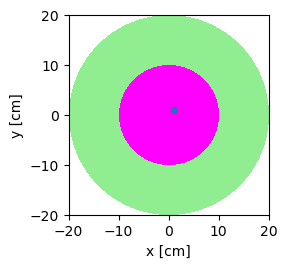

In [3]:
plot_kwargs = {
    'color_by' : 'material',
    'n_samples': 500,
    'plane_tolerance': 100.0,
    'source_kwargs': {'marker': '.'},
    'colors': {inner: 'magenta', outer: 'lightgreen'}
}

model.plot(**plot_kwargs)

The source shows up as a single point, as expected. Also note that when we don't specify anything for the angle distribution, it defaults to isotropic and the energy distribution defaults to a Watt fission spectrum.

Let's change the source to a box source covering the inner cylinder.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

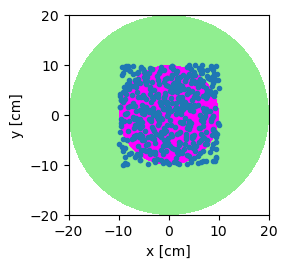

In [4]:
bbox = inner.bounding_box
space = openmc.stats.Box(bbox.lower_left, bbox.upper_right)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

The `openmc.stats.Box` will uniformly sample within a paralleliped - the same source distribution could also have been achieved by independently setting the sampling distributions for the x, y, and z directions with the `openmc.stats.CartesianIndependent` class.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

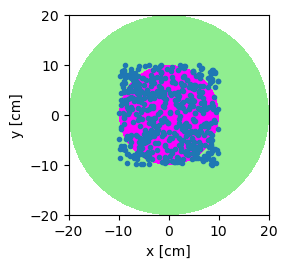

In [5]:
space = openmc.stats.CartesianIndependent(
    x=openmc.stats.Uniform(-10, 10),
    y=openmc.stats.Uniform(-10, 10),
    z=openmc.stats.Uniform(bbox.lower_left[-1], bbox.upper_right[-1]))
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

If we want the points to appear only in the cylinder, we can use the `openmc.stats.CylindricalIndependent` class.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

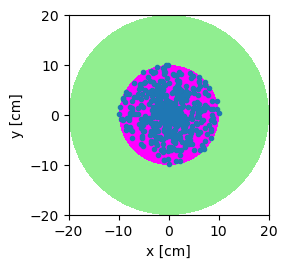

In [6]:
space = openmc.stats.CylindricalIndependent(
    r=openmc.stats.Uniform(0., 10.),
    phi=openmc.stats.Uniform(0., 2*math.pi),
    z=openmc.stats.delta_function(0.0)
)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

Notice that the points are not uniformly distributed over the cylinder (_volumetrically_), preferrentially clustering at smaller radii. To make it uniform, the radial distribution needs to be power-law distributed (which has a PDF of $cx^ndx$). Here, we are essentially weighting by `r`, because the cylindrical differential volume element is $rdrd\theta dz$.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

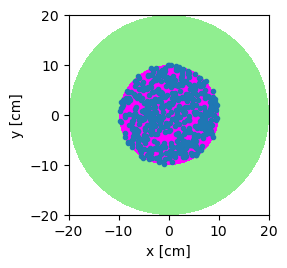

In [7]:
space = openmc.stats.CylindricalIndependent(
    r=openmc.stats.PowerLaw(0., 10., 1),
    phi=openmc.stats.Uniform(0., 2*math.pi),
    z=openmc.stats.delta_function(0.0)
)
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

## Constraints

OpenMC allows for source distributions to be further constrained, by setting the `constraints` parameter to a dictionary. For instance, this could be used to further reject source sites if they are not within a particular domain (cell, material, universe).

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

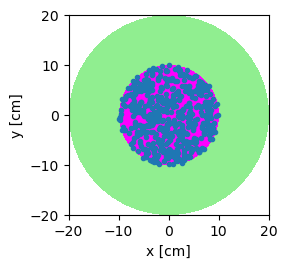

In [8]:
space = openmc.stats.Box(bbox.lower_left, bbox.upper_right)
model.settings.source = openmc.IndependentSource(space=space, constraints={'domains': [inner]})
model.plot(**plot_kwargs)

Or, we could have restricted the source to only the fissionable regions.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

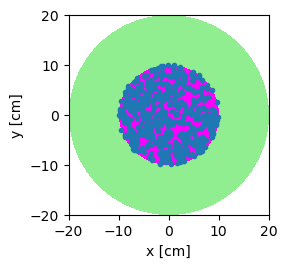

In [9]:
space = openmc.stats.Box(bbox.lower_left*2, bbox.upper_right*2)
model.settings.source = openmc.IndependentSource(space=space, constraints={'fissionable': True})
model.plot(**plot_kwargs)

### Angle and Energy Distributions

To change the angle or energy distribution, we use the `angle=` and `energy=` arguments when creating an instance of `IndependentSource`. For the angle distribution, our options are:

- `openmc.stats.Isotropic`
- `openmc.stats.Monodirectional`
- `openmc.stats.PolarAzimuthal`

For the energy distribution, any univariate distribution is accepted, which includes:

- `openmc.stats.Discrete`
- `openmc.stats.ContinuousTabular`
- `openmc.stats.Uniform`
- `openmc.stats.Mixture`
- `openmc.stats.Normal`
- ...

See [here](https://docs.openmc.org/en/latest/pythonapi/stats.html) for the full list of univariate distributions. Also note that for the common case where you want the source at a single energy, you can use the `delta_function` function (or a `Discrete` distribution with a single energy value).

For example, to adjust our neutron source to be a combination of neutrons at 10 MeV (40% of the neutrons) and 14.1 MeV (60% of the neutrons), traveling in the $+\hat{y}$ direction, we would use the following.

In [10]:
energy = openmc.stats.Discrete([10.0e6, 14.1e6], [0.4, 0.6])
angle = openmc.stats.Monodirectional([0, 1, 0])
model.settings.source = openmc.IndependentSource(energy=energy, angle=angle, space=space)

## `FileSource`

The `FileSource` class allows you to specify a source from an external HDF5 file that contains a finite number of discrete source sites. Source files can be created in a number of manners:

- $k$-eigenvalue calculations will store the initial fission source in the statepoint file (or write any batch's source to a separate source file).
- A surface source can be collected during a simulation using the `Settings.surf_source_write` setting.
- Discrete source sites can be created in the Python API and written to file using the `openmc.ParticleList` class.
- An [MCPL](https://mctools.github.io/mcpl/) (Monte Carlo Particle Lists) file written from another code can be used.

Let's demonstrate how we can create a source file using the `ParticleList` class. This class takes a list of `SourceParticle` objects that we create individually. Let's start by creating monoenergetic points along a ring.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

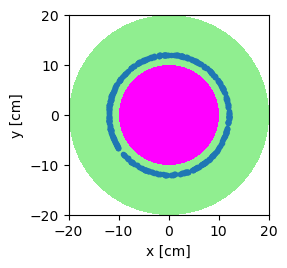

In [11]:
radius = 12.0

particles = openmc.ParticleList()
for i in range(1000):
    phi = random.uniform(0., 2.*math.pi)
    x = math.cos(phi) * radius
    y = math.sin(phi) * radius
    p = openmc.SourceParticle(r=(x, y, 0.0))
    particles.append(p)

particles.export_to_hdf5('source.h5')
model.settings.source = openmc.FileSource('source.h5')
model.plot(**plot_kwargs)

Let's add a little "wobble" to the sampled source sites by making the radius a sine function.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

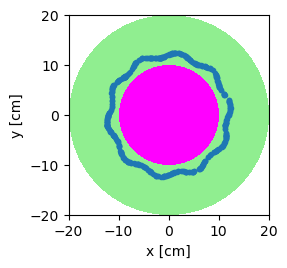

In [12]:
particles = openmc.ParticleList()
for i in range(1000):
    phi = random.uniform(0., 2.*math.pi)
    x = math.cos(phi) * (radius + 0.5*math.sin(10*phi))
    y = math.sin(phi) * (radius + 0.5*math.sin(10*phi))
    p = openmc.SourceParticle(r=(x, y, 0.0))
    particles.append(p)

particles.export_to_hdf5('source.h5')
model.settings.source = openmc.FileSource('source.h5')
model.plot(**plot_kwargs)

Let's also show how to write the fission source from a k-eigenvalue calculation. Since the source changes with each batch, we need to explicitly indicate at which batch we want to write the source. We write the source to a separate file, named `source.<batch>.h5`.

In [13]:
model.settings.particles = 5000
model.settings.inactive = 50
model.settings.batches = 55

model.settings.sourcepoint = {'batches' : [1, 55], 'separate' : True, 'write' : True}
statepoint = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [14]:
!ls

initial_source.h5 source.01.h5      statepoint.20.h5  surface_source.h5
model.xml         source.55.h5      statepoint.55.h5
solution-10.ipynb source.h5         summary.h5


We could then load this source into a new simulation. By inspecting the two sources, we can clearly see how after just one batch, the remnants of our sine wave source are still sort of visible (not easy for our neutrons to reach far into the fuel to cause fission, as many fission in the outer layer of the fuel).

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

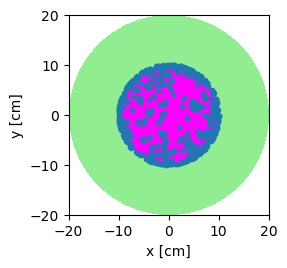

In [15]:
model.settings.source = openmc.FileSource('source.01.h5')
model.plot(**plot_kwargs)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

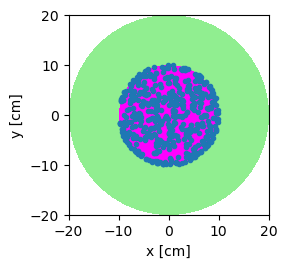

In [16]:
model.settings.source = openmc.FileSource('source.55.h5')
model.plot(**plot_kwargs)

## `MeshSource` and `MeshSpatial`

Finally, there are two classes that allow us to define a source distributed on a mesh:

- `MeshSpatial`: for this class, we can specify source intensities on each mesh element and then use it within `IndependentSource`
- `MeshSource`: this class behaves like `MeshSpatial` except it allows unique energy and angle distributions for each mesh element.

We'll demonstrate the simpler `MeshSpatial` class.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

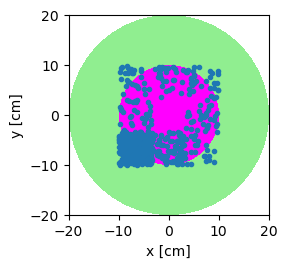

In [17]:
mesh = openmc.RegularMesh()
mesh.lower_left = (-10., -10., -1.)
mesh.upper_right = (10., 10., 1.)
mesh.dimension = (3, 3, 1)

space = openmc.stats.MeshSpatial(mesh, strengths=[9.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0])
model.settings.source = openmc.IndependentSource(space=space)
model.plot(**plot_kwargs)

## Combining Multiple Sources

You can also superimpose multiple sources - this is done by passing a list to `model.settings.source`. The default source strength in OpenMC is unity, so we can control the relative amounts of each source using the `strength` parameter.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

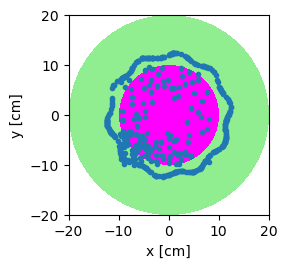

In [18]:
model.settings.source = [openmc.IndependentSource(space=space, strength=0.3), openmc.FileSource(path='source.h5', strength=0.7)]
model.plot(**plot_kwargs)

# Surface Sources

Let's now demonstrate how to write a surface source with OpenMC, which you may use to then run a second OpenMC calculation starting from those source particles. For example, this could be used to find the surface source on the outside of a reactor (with vacuum outside) using a k-eigenvalue calculation, to then load this source into a second fixed source calculation only considering the shielding outside the reactor. Of course, this example is an approximation to the integrated problem when both domains are present - but this notion of splitting a domain into separate runs is often used for experiment analysis.

Let's record all the particles which cross from the aluminum into the fuel. To do so, we'll set a dictionary named `surf_source_write` in the settings. The particles added to the surface source will simply be added starting from the active batches, until reaching the desired number per rank.

In [19]:
model.settings.surf_source_write = {'surface_ids' : [cyl1.id], 'max_particles' : 1000, 'cellfrom' : outer.id}
model.settings.particles = 4000

In [20]:
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/Users/anovak/projects/openmc-education/sources-fixed-source-10/statepoint.55.h5')

In [21]:
!ls

initial_source.h5 source.01.h5      statepoint.20.h5  surface_source.h5
model.xml         source.55.h5      statepoint.55.h5
solution-10.ipynb source.h5         summary.h5


To read in this surface source, we can load it with the `surf_source_read` parameter, which should be passed the path to the surface source file. Let's now modify our geometry to replace the fuel with some other goemetry, as if we were using a surface source for a typical experiment design procedure. If we want to run with only that surface source, we need to remove the wobbly ring source and our mesh source from earlier.

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

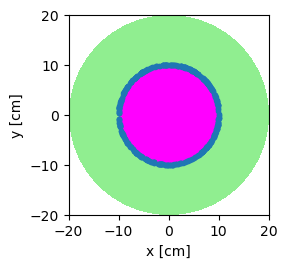

In [22]:
model.settings.source = []
model.settings.surf_source_read = {'path' : 'surface_source.h5'}
model.plot(**plot_kwargs)

We'll now run this as a fixed source calculation - all we need to do is modify the `run_mode`. With a fixed source calculation, there is no notion of inactive batches, so we will run all of our batches as active.

In [23]:
model.settings.run_mode = 'fixed source'
model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

RuntimeError: The secondary particle bank appears to be growing without bound. You are likely running a subcritical multiplication problem with k-effective close to or greater than one. Abort(-1) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, -1) - process 0